In [72]:
import numpy as np
from astropy.table import Table, vstack
import thecannon as tc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#from mpi4py import MPI
import multiprocess as mp
from multiprocess import Pool
import os
import tqdm

from astroquery.gaia import Gaia
from astropy.table import Table

## Read in data
Start off just with APOGEE x DR3 Data

Load in labels:

In [85]:
t_apogee_all = Table.read("apogee_w2m_clean.fits", format='fits')

In [86]:
t_apogee_all

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,"FPARAM_GRID [21,9]",CHI2_GRID [21],FPARAM [9],"FPARAM_COV [9,9]",ASPCAP_CHI2,PARAM [9],"PARAM_COV [9,9]",PARAMFLAG [9],ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM [27],FELEM_ERR [27],X_H [27],X_H_ERR [27],X_M [27],X_M_ERR [27],ELEM_CHI2 [27],ELEMFRAC [27],ELEMFLAG [27],EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC [27],X_M_SPEC [27],TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK [100],2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD,angDist,JNAME,ra_x,dec_x,errHalfMaj_x,errHalfMin_x,errPosAng_x,W1mag,W2mag,W3mag,W4mag,Jmag_x,Hmag_x,Kmag_x,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag_x,e_Hmag_x,e_Kmag_x,cntr,cc_flags,ext_flg,var_flg,ph_qual,r_2mass,angDist_x,source_id
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,,,,d,arcsec,,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,arcsec,
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,

In [87]:
Gaia.login(user='cmanea', password='BB8meetspepper.')

Gaia.upload_table(upload_resource=t_apogee_all['source_id', 'APOGEE_ID'], table_name='apogee_ids')

table_name = 'user_cmanea.apogee_ids'

INFO:astroquery:Login to gaia TAP server


INFO: Login to gaia TAP server [astroquery.gaia.core]


INFO:astroquery:Login to gaia data server


OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
Sending pytable.
Uploaded table 'apogee_ids'.


Read in Gaia BP RP coeffs, errs, truncation recommendations, and basis functions

In [ ]:
query = 'select t.*, t2.* from gaiadr3.xp_continuous_mean_spectrum as t inner join ' + table_name +' as t2 on t.source_id = t2.source_id where t.bp_n_measurements>0 and t.rp_n_measurements>0 '

job = Gaia.launch_job_async(query, dump_to_file=True, output_format='votable')

gaia_bprp_spectra = job.get_results()

In [ ]:
gaia_bprp_spectra

In [ ]:
bps = gaia_bprp_spectra['bp_coefficients']
bp_errs = gaia_bprp_spectra['bp_coefficient_errors']
bp_rel_bases = gaia_bprp_spectra['bp_n_relevant_bases']
max_bp_bases = np.nanmax(bp_rel_bases)
bp_basis_func = gaia_bprp_spectra['rp_basis_function_id']

rps = gaia_bprp_spectra['rp_coefficients']
rp_errs = gaia_bprp_spectra['rp_coefficient_errors']
rp_rel_bases = gaia_bprp_spectra['rp_n_relevant_bases']
max_rp_bases = np.nanmax(rp_rel_bases)
rp_basis_func = gaia_bprp_spectra['rp_basis_function_id']


Truncate to relevant bases and combine

In [ ]:
bps_trunc = bps[:, :max_bp_bases]
bp_errs_trunc = bp_errs[:, :max_bp_bases]

rps_trunc = rps[:, :max_rp_bases]
rp_errs_trunc = rp_errs[:, :max_rp_bases]

bprps = np.zeros((len(bps_trunc), max_bp_bases+max_rp_bases))
bprp_errs = np.zeros((len(bps_trunc), max_bp_bases+max_rp_bases))

bprps[:,:max_bp_bases] = bps_trunc
bprp_errs[:,:max_bp_bases] = bp_errs_trunc

bprps[:,max_bp_bases:] = rps_trunc
bprp_errs[:,max_bp_bases:] = rp_errs_trunc

Load in Gaia BP RP "spectra" (Hermite coefficients):

In [53]:
# import time
# size = len(t) #adjust if you only want to play with subset of data
# start_time = time.time()
# p = Pool(os.cpu_count()-2)
# results = np.array(p.map(read_in_data, range(size)))
# xs = np.array(results)[:,0,:]
# xerrs = np.array(results)[:,1,:]
# print(time.time() - start_time, ' s')
# print(size)

#read in gaia bp rp coeffs
#t_all = Table.read(gaia_spectra_file, format='fits')

#divide into coeffs and coef errs, replace with real values
xs = np.zeros((len(t_apogee_all), 800)) #first index is number of sources, second index is num of coeffs.
xerrs = np.zeros((len(t_apogee_all), 800))

Tack WISE, 2MASS photometry onto end of coefficient arrays

In [66]:
#add photometry
phots_matrix = np.zeros((len(t_apogee_all), 7))
photerrs_matrix = np.zeros((len(t_apogee_all), 7))
phots_matrix[:, 0] = np.array(t_apogee_all['GAIAEDR3_PHOT_BP_MEAN_MAG']).astype(float)
phots_matrix[:, 1] = np.array(t_apogee_all['GAIAEDR3_PHOT_BP_MEAN_MAG']).astype(float)
phots_matrix[:, 2] = np.array(t_apogee_all['Jmag']).astype(float)
phots_matrix[:, 3] = np.array(t_apogee_all['Hmag']).astype(float)
phots_matrix[:, 4] = np.array(t_apogee_all['Kmag']).astype(float)
phots_matrix[:, 5] = np.array(t_apogee_all['W1mag']).astype(float)
phots_matrix[:, 6] = np.array(t_apogee_all['W2mag']).astype(float)
# phots_matrix[:, 7] = np.array(t_apogee['W3']).astype(float)
# phots_matrix[:, 8] = np.array(t_apogee['W4']).astype(float)

photerrs_matrix[:, 0] = np.array(t_apogee_all['e_Jmag']).astype(float)
photerrs_matrix[:, 1] = np.array(t_apogee_all['e_Jmag']).astype(float)
photerrs_matrix[:, 2] = np.array(t_apogee_all['e_Jmag']).astype(float)
photerrs_matrix[:, 3] = np.array(t_apogee_all['e_Hmag']).astype(float)
photerrs_matrix[:, 4] = np.array(t_apogee_all['e_Kmag']).astype(float)
photerrs_matrix[:, 5] = np.array(t_apogee_all['e_W1mag']).astype(float)
photerrs_matrix[:, 6] = np.array(t_apogee_all['e_W2mag']).astype(float)
# photerrs_matrix[:, 7] = np.array(t_apogee['W3_err']).astype(float)
# photerrs_matrix[:, 8] = np.array(t_apogee['W4_err']).astype(float)


xs_with_phot = np.zeros((xs.shape[0],xs.shape[1]+7))
xerrs_with_phot = np.zeros((xs.shape[0],xs.shape[1]+7))

xs_with_phot[:,:xs.shape[1]] = xs
xerrs_with_phot[:,:xs.shape[1]] = xerrs

xs_with_phot[:,xs.shape[1]:] = phots_matrix
xerrs_with_phot[:,xs.shape[1]:] = photerrs_matrix
phots_matrix.shape, xs_with_phot.shape



((597586, 7), (597586, 807))

Create an evenly sampled APOGEE Training Set

[-2.0000000e+00 -1.8000000e+00 -1.6000000e+00 -1.4000000e+00
 -1.2000000e+00 -1.0000000e+00 -8.0000000e-01 -6.0000000e-01
 -4.0000000e-01 -2.0000000e-01 -4.4408921e-16  2.0000000e-01
  4.0000000e-01]
-0.4828255 [-0.48282549 -0.1764543   0.12991689  0.43628809  0.74265928  1.04903047
  1.35540166  1.66177285  1.96814404  2.27451523  2.58088643  2.88725762
  3.19362881  3.5       ]
(array([  1770,   2684,   3824,   5486,   6507,   9802,  30515,  83790,
       131930, 162939, 114298,  39406]), array([-2.0000000e+00, -1.8000000e+00, -1.6000000e+00, -1.4000000e+00,
       -1.2000000e+00, -1.0000000e+00, -8.0000000e-01, -6.0000000e-01,
       -4.0000000e-01, -2.0000000e-01, -4.4408921e-16,  2.0000000e-01,
        4.0000000e-01]))


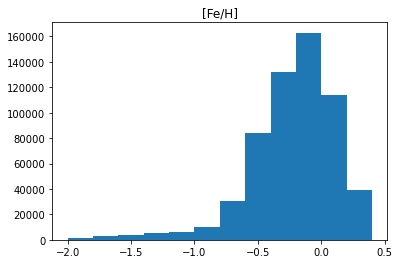

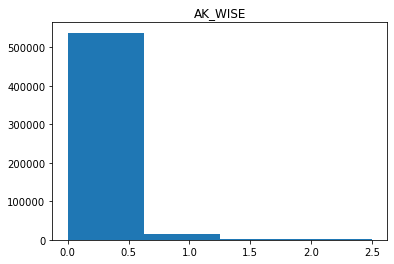

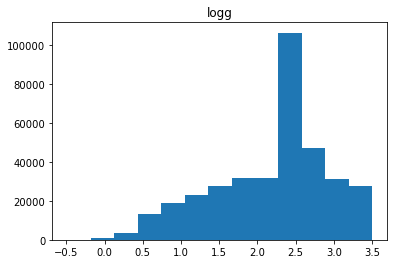

In [67]:
feh_bins = np.arange(-2, 0.5, .2)
print(feh_bins)
extinction_bins = np.linspace(0, 2.5, 5)
logg_bins = np.linspace(np.min(t_apogee_all['LOGG']), 3.5, 14)
#logg_bins = [np.min(t['logg']), 1, 1.60994217, 2.55497108, 3.5]
print(np.min(t_apogee_all['LOGG']),logg_bins)

print(np.histogram(t_apogee_all['M_H'], bins = feh_bins))

plt.figure()
plt.hist(t_apogee_all['M_H'], bins=feh_bins)
plt.title('[Fe/H]')
plt.show()
plt.close()

plt.figure()
plt.hist(t_apogee_all['AK_WISE'], bins=extinction_bins)
plt.title('AK_WISE')
plt.show()
plt.close()

plt.figure()
plt.hist(t_apogee_all['LOGG'], bins=logg_bins)
plt.title('logg')
plt.show()
plt.close()

In [68]:
# feh_bins = np.linspace(-1.25, 0.25, 15)
# extinction_bins = np.linspace(0, 3, 4)
# parallax_bins = np.linspace(np.min(t_apogee['GAIAEDR3_PARALLAX']), 4, 10)



#only doing feh and extinction for now:
c = 0
e = 0
for i in range(len(feh_bins)-1):
    for j in range(len(extinction_bins)-1):
        for k in range(len(logg_bins)-1):
            c+=1
            #print(feh_bins[i], '-', feh_bins[i+1], extinction_bins[j], '-', extinction_bins[j+1], logg_bins[k], '-', logg_bins[k+1])
            if i == len(feh_bins)-1:
                if j == len(extinction_bins)-1:
                    if k == len(parallax_bins)-1:
                        good = np.where((t_apogee_all['GAIAEDR3_PHOT_G_MEAN_MAG']<17.6) & (t_apogee_all['M_H'] > feh_bins[i]) & (t_apogee_all['AK_WISE'] > extinction_bins[j])  & (t_apogee_all['LOGG'] > logg_bins[k]))
                    else:
                        good = np.where((t_apogee_all['GAIAEDR3_PHOT_G_MEAN_MAG']<17.6) & (t_apogee_all['M_H'] > feh_bins[i]) & (t_apogee_all['AK_WISE'] > extinction_bins[j])  & (t_apogee_all['LOGG'] > logg_bins[k]) & (t_apogee_all['LOGG'] <= logg_bins[k+1]))
                else:
                    good = np.where((t_apogee_all['GAIAEDR3_PHOT_G_MEAN_MAG']<17.6) & (t_apogee_all['M_H'] > feh_bins[i]) & (t_apogee_all['AK_WISE'] > extinction_bins[j]) & (t_apogee_all['AK_WISE'] <= extinction_bins[j+1]) & (t_apogee_all['LOGG'] > logg_bins[k]) & (t_apogee_all['LOGG'] <= logg_bins[k+1]))
            else:
                good = np.where((t_apogee_all['GAIAEDR3_PHOT_G_MEAN_MAG']<17.6) & (t_apogee_all['M_H'] <= feh_bins[i+1]) & (t_apogee_all['M_H'] > feh_bins[i]) & (t_apogee_all['AK_WISE'] > extinction_bins[j]) & (t_apogee_all['AK_WISE'] <= extinction_bins[j+1]) & (t_apogee_all['LOGG'] > logg_bins[k]) & (t_apogee_all['LOGG'] <= logg_bins[k+1]))
            if good[0].size <2:
                if (i == 0) & (j == 0):
                    training_index = [good[0][:1]]
                e+=1
#                 print('Empty Voxel')
#                 print('FeH: ', feh_bins[i], '-', feh_bins[i+1], '\n Extinction: ', extinction_bins[j], '-', extinction_bins[j+1], '\n Logg: ', logg_bins[k], '-', logg_bins[k+1])
#                 print(good[0], ' \n\n\n')
                training_index = np.append(training_index,good[0][:1])
            else:
                if (i == 0) & (j == 0):
                    training_index = [good[0][:1]]
                else:
                    training_index = np.append(training_index,good[0][:1])
print('Number of Voxels: ',c, 'Number empty: ', e)
# good = np.where((t_apogee_all['GAIAEDR3_PHOT_G_MEAN_MAG']<17.6) & (t_all['feh'] > 0.22222) & (t_all['A_v'] <3)  & (t_all['logg'] < 0.97992289))              
# training_index = np.append(training_index,good[0])
#define evenly sampled training set
t_apogee_cleantrain = t_apogee_all[training_index]
# xs_with_phot_cleantrain = xs_with_phot[training_index]
# xerrs_with_phot_cleantrain = xerrs_with_phot[training_index]

print(t_apogee_cleantrain)



Number of Voxels:  624 Number empty:  287
                FILE                    APOGEE_ID      ... r_2mass angDist_x
                                                       ...           arcsec 
----------------------------------- ------------------ ... ------- ---------
asStar-dr17-2M06014757-5951510.fits 2M06014757-5951510 ...   0.428  0.427861
apStar-dr17-2M19135986-0543519.fits 2M19135986-0543519 ...   0.134  0.133924
asStar-dr17-2M16562942-3949345.fits 2M16562942-3949345 ...   0.096  0.095919
apStar-dr17-2M13385588+1842417.fits 2M13385588+1842417 ...   0.197  0.197151
apStar-dr17-2M22043983-0711337.fits 2M22043983-0711337 ...   0.089  0.089713
asStar-dr17-2M04572884-7027294.fits 2M04572884-7027294 ...   0.118  0.118061
                                ...                ... ...     ...       ...
asStar-dr17-2M18260007-1145026.fits 2M18260007-1145026 ...   0.379  0.379415
asStar-dr17-2M18200091-1554284.fits 2M18200091-1554284 ...    0.17  0.170349
apStar-dr17-2M18362063-0741208.fit

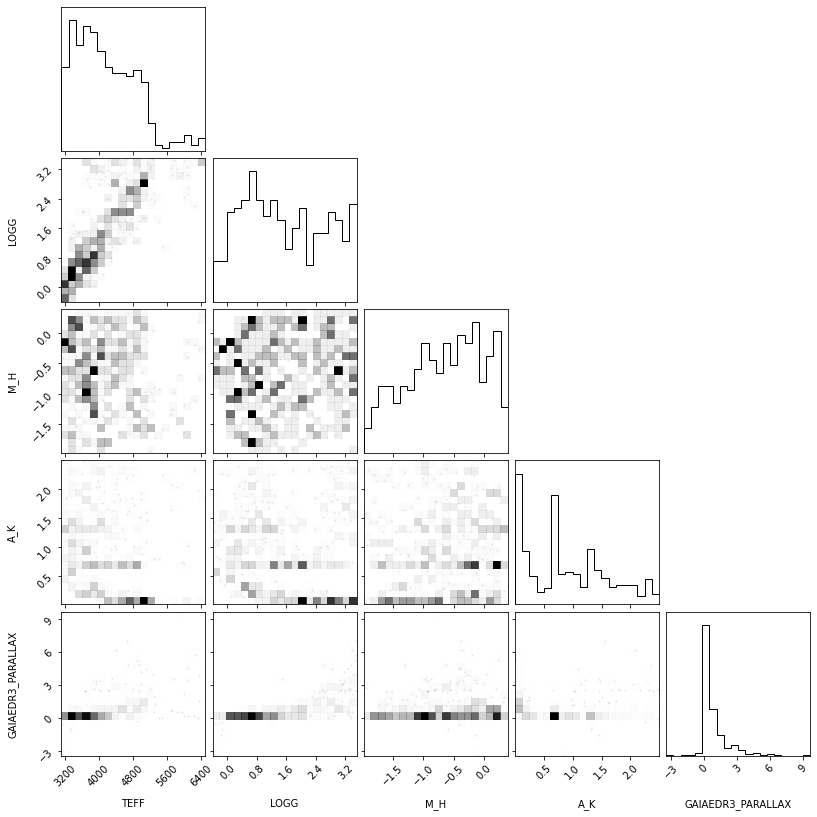

In [69]:
import corner


# ndim, nsamples = 2, 10000
# np.random.seed(42)
# samples = np.array(list(np.array(t_cleantrain['Teff', 'logg', 'A_v', 'feh'])))
# figure = corner.corner(samples)

df = t_apogee_cleantrain['TEFF', 'LOGG', 'M_H', 'AK_WISE', 'GAIAEDR3_PARALLAX'].to_pandas()
figure = corner.corner(df, plot_contours=False, labels=['TEFF', 'LOGG', 'M_H', 'A_K', 'GAIAEDR3_PARALLAX'], fontsize=12)
plt.savefig('apogee_trainingset_clean_corner.pdf')

In [588]:
t_cleantrain['GAIAEDR3_SOURCE_ID', 'APOGEE_ID', 'Teff', 'logg', 'feh', 'A_v', 'SNR'].write('clean_apogee_sample_smoothlogg2.fits', format='fits', overwrite=True)

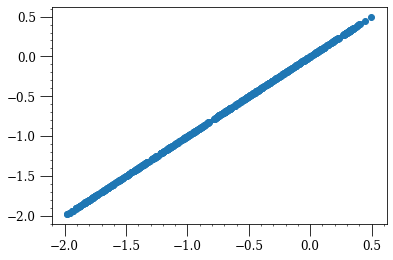

Teff,logg,feh,c_fe,A_v,SNR,synth,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_SOURCE_ID,APOGEE_ID
float64,float64,float64,float64,float64,float64,bool,float32,int64,bytes30
5194.12255859375,3.3309779167175293,-1.9431999921798706,--,0.30600249767303467,430.9967041015625,True,10.007,5494465006512656000,2M06014757-5951510
4229.07470703125,0.5284929275512695,-1.8515000343322754,--,0.7414605617523193,151.5426025390625,True,15.6522,5281650137208867328,2M06531651-6717256
4702.80078125,1.4378466606140137,-1.8753999471664429,--,1.0239241123199463,647.6806030273438,True,10.696,2106022408847412224,2M19084163+4352103
4956.68212890625,2.249962091445923,-1.93340003490448,--,1.0239241123199463,745.89306640625,True,10.0724,1505148615752865408,2M14130915+4511429
5114.31689453125,2.834345579147339,-1.7755999565124512,--,0.835618793964386,506.7528381347656,True,10.2682,781931511003780096,2M10595749+4446439
4198.8720703125,0.6195313334465027,-1.8487000465393066,--,1.565308690071106,1084.00244140625,True,10.1472,4574503150813959936,2M17203925+2810346
...,...,...,...,...,...,...,...,...,...
3439.666748046875,0.7778753042221069,0.33889999985694885,--,9.026998519897461,567.2501831054688,True,14.9328,4159323437020010368,2M18255380-0814291
4367.50146484375,1.9802837371826172,0.28995999693870544,--,9.203535079956055,566.837890625,True,14.6669,5972935534515501952,2M17104054-3943497


In [561]:
plt.figure()
plt.scatter(t_cleantrain['feh'], t_apogee_cleantrain['M_H'])
plt.show()
t_cleantrain

Choose subset of data for training and testing (uncomment relevant cell)

In [153]:
# # **Giants**

# subset = np.where((t['Teff'] < 5500) & (t['logg'] < 3) & (t['A_v'] < 1) & (t['A_v'] > 0))
# t_subset = t[subset]
# xs_subset = xs_with_phot[subset]
# xerrs_subset = xerrs_with_phot[subset]

(3318, 904)


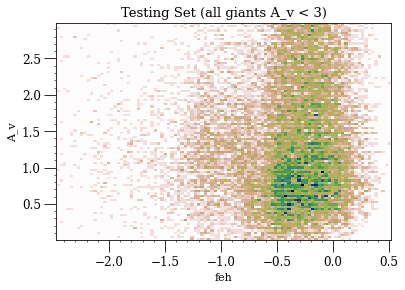

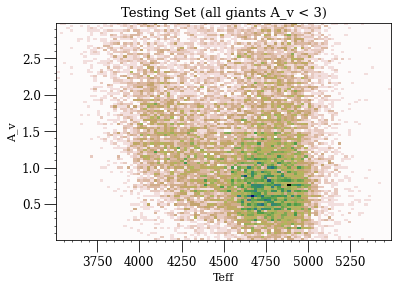

In [333]:
# # **Giants and Less Restrictive A_v



print(xs_with_phot_cleantrain.shape)

#training subsets
train_subset = training_index
t_train_subset = t_cleantrain
xs_train_subset = xs_with_phot_cleantrain[train_subset]
xerrs_train_subset = xerrs_with_phot_cleantrain[train_subset]

#testing subsets
test_subset = np.where((t['Teff'] < 5500) & (t['logg'] < 3) & (t['A_v'] > 0) & (t['A_v'] <3))
t_test_subset = t[test_subset]
xs_test_subset = xs_with_phot[test_subset]
xerrs_test_subset = xerrs_with_phot[test_subset]

#remove bad spectra
bad = np.where(np.isnan(np.mean(xs_train_subset,axis=1)))
xs_train_subset = np.delete(xs_train_subset, bad, axis=0)
xerrs_train_subset = np.delete(xerrs_train_subset, bad, axis=0)
t_train_subset.remove_rows(bad[0])

bad = np.where(np.isnan(np.mean(xs_test_subset,axis=1)))
xs_test_subset = np.delete(xs_test_subset, bad, axis=0)
xerrs_test_subset = np.delete(xerrs_test_subset, bad, axis=0)
t_test_subset.remove_rows(bad[0])

plt.figure()
plt.hist2d(t_test_subset['feh'], t_test_subset['A_v'], bins=100, cmap='gist_earth_r')
plt.xlabel('feh')
plt.ylabel('A_v')
plt.title('Testing Set (all giants A_v < 3)')
plt.show()

plt.figure()
plt.hist2d(t_test_subset['Teff'], t_test_subset['A_v'], bins=100, cmap='gist_earth_r')
plt.xlabel('Teff')
plt.ylabel('A_v')
plt.title('Testing Set (all giants A_v < 3)')
plt.show()

In [141]:
# # **DWARFS**

# subset = np.where((t['Teff'] < 6500) & (t['Teff'] > 4500) & (t['logg'] > 4) & (t['A_v'] < 1) & (t['A_v'] > 0))
# t_subset = t[subset]
# xs_subset = xs_with_phot[subset]
# xerrs_subset = xerrs_with_phot[subset]

In [ ]:
# **Dwarfs+Giants**
# subset = np.where((t['Teff'] < 6500) & (t['A_v'] < 10) & (t['A_v'] > 0))
# t_subset = t[subset]
# xs_subset = xs_with_phot[subset]
# xerrs_subset = xerrs_with_phot[subset]

Normalize data according to desired scheme (max, min-max, deviation from mean, etc.)

In [595]:
#remove magnitude information by dividing by max coefficient
#furthermore, scale photometry by bp mag
max_spectrum = np.nanmax(xs_train_subset, axis=1)
xs_train_subset_maxnorm = xs_train_subset
max_grid = np.repeat(max_spectrum, xs_train_subset.shape[1]).reshape(xs_train_subset.shape[0], xs_train_subset.shape[1])
bps = np.repeat(xs_train_subset[:,-7], 7).reshape(xs_train_subset.shape[0], 7)
xs_train_subset_maxnorm[:,:-7] = xs_train_subset[:,:-7]/max_grid[:,:-7]
xs_train_subset_maxnorm[:,-7:] = xs_train_subset[:,-7:]/bps

#rescale each spectrum
mean_spectrum = np.nanmean(xs_train_subset_maxnorm, axis=0)
mean_grid = np.repeat(mean_spectrum, xs_train_subset.shape[0]).reshape(xs_train_subset.shape[1], xs_train_subset.shape[0]).T

xs_train_subset_maxmeannorm = xs_train_subset_maxnorm/mean_grid
xs_train_subset_maxmeannorm

(2304, 904) (2304, 904)


Separate training and testing sets, reassign NaN and inf values:

In [307]:
#making training and testing sets
# train_inds = np.random.choice(range(len(t)),int(.6*len(t)),replace=False)
# test_inds = np.array(list(set(range(len(t)))- set(train_inds)),dtype='int')

train_xs = xs_train_subset
train_errs = xerrs_train_subset

test_xs = xs_test_subset
test_errs = xerrs_test_subset

# bad = np.where(np.isnan(train_xs))
# train_xs[bad] = 0.0000001
# bad = np.where(np.isnan(train_errs))
# train_errs[bad] = 0.0000001
bad = np.where(train_xs==np.inf)
train_xs[bad] = 1e6
bad = np.where(train_errs==np.inf)
train_errs[bad] = 1e6
bad = np.where(np.isnan(train_errs))
train_errs[bad] = 1e-6


bad = np.where(test_xs==np.inf)
test_xs[bad] = 1e6
bad = np.where(test_errs==np.inf)
test_errs[bad] = 1e6

train_t = t_train_subset
test_t = t_test_subset

print(len(train_t), len(test_t))

np.where(np.isnan(train_errs))

2304 20940


(array([], dtype=int64), array([], dtype=int64))

Specify vectorizer, set up and train the model:

In [308]:
# # Specify the vectorizer.
# vectorizer = tc.vectorizer.PolynomialVectorizer(("Teff", "logg", "feh", "A_v"), 2)
# # set up model
# model = tc.CannonModel(train_t, train_xs, train_errs,
#                        vectorizer=vectorizer, dispersion=wf)


vectorizer = tc.vectorizer.PolynomialVectorizer(("Teff", "logg", "feh", "A_v"), 2)

model = tc.CannonModel(train_t, train_xs, train_errs, vectorizer=vectorizer)
# # No regularization.
model.regularization = 0

# Train the model!
model.train()


2022-06-09 18:08:02,728 [INFO] Training 4-label CannonModel with 2304 stars and 904 pixels/star
stty: 2022-06-09 18:08:02,753 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[=====                                                                                               ]   5% (48/904)                          

stdin isn't a terminal


[====================================================================================================] 100% (2s)                               


(array([[ 1.34977330e-04,  2.44766309e-04,  1.99589045e-04, ...,
         -9.35786183e-05,  2.30838431e-04,  4.70489248e-04],
        [ 2.63864389e-04,  4.75848395e-04,  3.87553498e-04, ...,
         -1.81700860e-04,  4.46154114e-04,  9.16042853e-04],
        [ 4.86533136e-04,  8.72378115e-04,  7.09687057e-04, ...,
         -3.32873524e-04,  8.13061474e-04,  1.68168201e-03],
        ...,
        [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0

Test the model:

In [309]:
#infer for train
test_labels, cov, metadata = model.test(test_xs, test_errs)


#fig_comparison = tc.plot.one_to_one(model, test_labels, latex_label_names=[r"T_{\rm eff}",r"\log{g}",r"[{\rm Fe}/{\rm H}]",r"{\rm A_V}"])
#fig_comparison.savefig(fig_path+"one-to-one.png", dpi=300)

stty: stdin isn't a terminal
2022-06-09 18:08:04,698 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2022-06-09 18:08:04,700 [INFO] Running test step on 20940 spectra


[====================================================================================================] 100% (180s)                                 


Plot difference between true and inferred values:

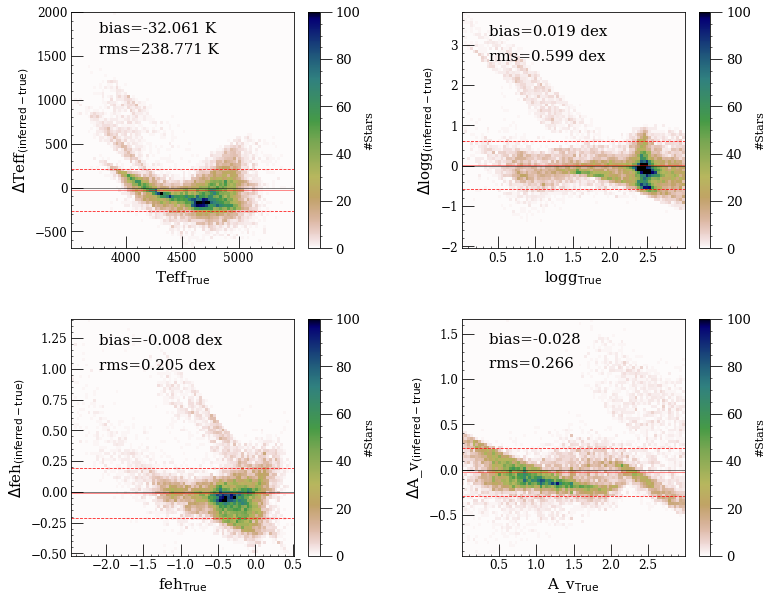

In [312]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'regular',
        'size'   : 11}

import matplotlib
fig, axs = plt.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
plt.rc('font', **font)
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["xtick.minor.visible"] =  True

    
unit = ['K', 'dex', 'dex', '']
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hist2d(t_test_subset[param],test_labels[:,i] - t_test_subset[param], bins=80,  cmap='gist_earth_r', vmin=0, vmax=100)
    ax.axhline(y=0, c='k', alpha=.99, lw=.5)
    bias = np.round(np.mean(test_labels[:,i] - t_test_subset[param]), 3)
    rms = np.round(np.std(test_labels[:,i] - t_test_subset[param]), 3)
    ax.axhline(y=bias, c='r', alpha=.9, lw=.5)
    ax.axhline(y=bias+rms, c='r', alpha=.9, lw=.8, ls='--')
    ax.axhline(y=bias-rms, c='r', alpha=.9, lw=.8, ls='--')
    offset = (np.max(t_test_subset[param]) - np.min(t_test_subset[param]))/8
    ax.text(offset+np.min(t_test_subset[param]), np.max(test_labels[:,i] - t_test_subset[param])-rms, "bias={a} {b}".format(a=bias, b=unit[i]), fontsize=15)
    ax.text(offset+np.min(t_test_subset[param]), np.max(test_labels[:,i] - t_test_subset[param])-(2*rms), "rms={a} {b}".format(a=rms, b=unit[i]), fontsize=15)
    #ax.text(0.1, 0.8, "rms={}".format(rms))
    cbar = fig.colorbar(h[3], ax=ax, label='#Stars')
    cbar.ax.tick_params(labelsize=13) 
    #ax.set_title(param)
    ax.set_xlabel(param+r"$\rm _{{}True{}}$", fontsize=15)
    ax.set_ylabel(r"$\rm \Delta$"+param+r"$\rm _{(inferred - true)}$", fontsize=15)
    ax.tick_params(axis="both", which='both', direction="in")
plt.savefig("Diagnostic_Figs/wise2mass_normmean/inferred_vs_true_GiantsAv3_cleantrain_hist2d.pdf")



# Ignore below

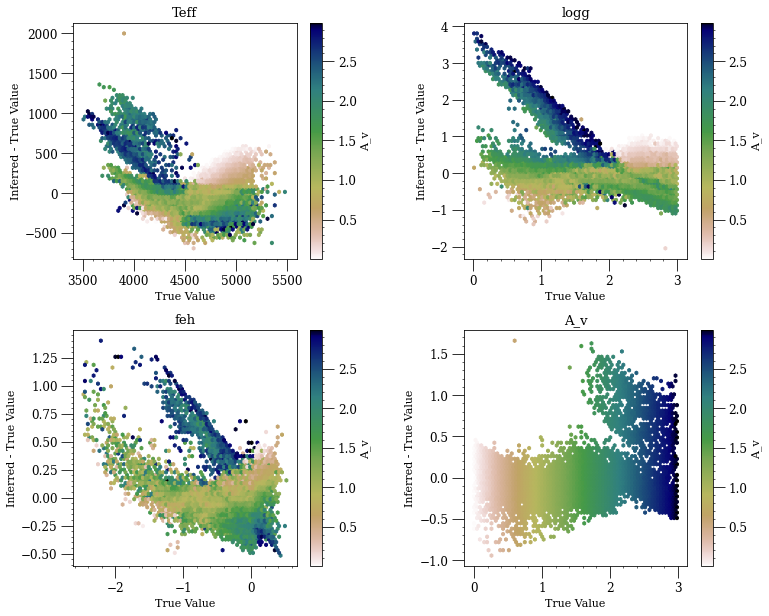

In [315]:
fig, axs = plt.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hexbin(t_test_subset[param],test_labels[:,i] - t_test_subset[param], gridsize=70, C=t_test_subset['A_v'], cmap='gist_earth_r')
    fig.colorbar(h, ax=ax, label='A_v')
    ax.set_title(param)
    ax.set_xlabel("True Value")
    ax.set_ylabel("Inferred - True Value")
plt.savefig("Diagnostic_Figs/wise2mass_normmean/inferred_vs_true_giants_colorAv.pdf")

In [ ]:
fig, axs = p.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    h = ax.hexbin(t_subset[param][test_inds],test_labels[:,i] - t_subset[param][test_inds], gridsize=40, C=t_subset['Teff'][test_inds])
    fig.colorbar(h, ax=ax, label='Teff')
    ax.set_title(param)
    ax.set_xlabel("True Value")
    ax.set_ylabel("Inferred - True Value")
p.savefig("Diagnostic_Figs/inferred_vs_true_giants_colorTeff.pdf")

Histograms of inferred and true values

In [ ]:
fig, axs = p.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, param in enumerate(['Teff', 'logg', 'feh', 'A_v']):
    ax = np.ravel(axs)[i]
    ax.hist(test_labels[:,i], alpha=.5, label='Inferred', bins=np.linspace(np.min(test_labels[:,i]), np.max(test_labels[:,i]), 10))
    ax.hist(t_subset[param][test_inds], alpha=.5, label='True', bins=np.linspace(np.min(test_labels[:,i]), np.max(test_labels[:,i]), 10))
    ax.set_title(param)
    ax.legend()

In [ ]:
print(np.mean(test_labels[:,0]))
print(np.mean(np.abs(test_labels[:,0]-t_subset['Teff'][test_inds])))
print(np.mean(np.abs(test_labels[:,1]-t_subset['logg'][test_inds])))
print(np.mean(t_subset['Teff'][test_inds]))

In [ ]:
print(np.min(t_subset['Teff'][test_inds]), np.max(t_subset['Teff'][test_inds]))
print(np.min(t_subset['Teff'][train_inds]), np.max(t_subset['Teff'][train_inds]))

In [ ]:
t = Table.read(table_path+'synth_apogee_0.fits')
t = t[t['synth']]
t_apogee = Table.read(table_path+'apogee_good_0.fits')
t_apogee_reordered = t_apogee

goods = []
for i in range(len(t)):
    if i%1000 == 0:
        print(i)
    spot = np.where((np.round(t_apogee['TEFF'], 2) == np.round(t['Teff'][i], 2)) & (np.round(t_apogee['LOGG'], 2) == np.round(t['logg'][i], 2)) & (np.round(t_apogee['M_H'], 3) == np.round(t['feh'][i], 3)) & (np.round(t_apogee['SNR'], 3) == np.round(t['SNR'][i], 3)))
    if len(spot[0]) == 1:
        spot = spot[0][0]
        #print(t['Teff'][i], t_apogee['TEFF'][spot])
        t_apogee_reordered[i] = t_apogee[spot]
        #print(t_apogee_reordered['TEFF'][i])
        goods.append(i)

print(len(goods))

t[goods].write(table_path+'synth_apogee_good.fits', format='fits', overwrite=True)
t_apogee_reordered[goods].write(table_path+'apogee_info_good.fits', format='fits', overwrite=True)
#np.round(t['Teff'][5], 2), np.round(t_apogee['TEFF'][5], 2)

In [ ]:
t_apogee = Table.read(table_path+'apogee_info_good.fits')
t_apogee_2mass_wise = Table.read(table_path+'apogee_2mass_wise.fits')

t_apogee['J'], t_apogee['H'], t_apogee['K'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))
t_apogee['W1'], t_apogee['W2'], t_apogee['W3'], t_apogee['W4'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))

t_apogee['J_err'], t_apogee['H_err'], t_apogee['K_err'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))
t_apogee['W1_err'], t_apogee['W2_err'], t_apogee['W3_err'], t_apogee['W4_err'] = np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee)), np.repeat(1e-6, len(t_apogee))


#t_apogee_2mass_wise['W3mag'][(t_apogee_2mass_wise['W3mag'] == np.empty).mask]

for i, ID in enumerate(t_apogee['APOGEE_ID'][:]):
    if i % 1000 == 0:
        print(np.round(100 * ind/len(t_apogee), 2))
    if ID in t_apogee_2mass_wise['APOGEE_ID']:
        spot = np.where(t_apogee_2mass_wise['APOGEE_ID'] == ID)
        if (spot[0].size>0):
            if (spot[0].size==1):
                if (t_apogee_2mass_wise['W3mag'][spot] != np.empty) & (t_apogee_2mass_wise['W4mag'][spot] != np.empty):
                    t_apogee['J'][i] = t_apogee_2mass_wise['Jmag'][spot]
                    t_apogee['H'][i] = t_apogee_2mass_wise['Hmag'][spot]
                    t_apogee['K'][i] = t_apogee_2mass_wise['Kmag'][spot]
                    t_apogee['W1'][i] = t_apogee_2mass_wise['W1mag'][spot]
                    t_apogee['W2'][i] = t_apogee_2mass_wise['W2mag'][spot]
                    t_apogee['W3'][i] = t_apogee_2mass_wise['W3mag'][spot]
                    t_apogee['W4'][i] = t_apogee_2mass_wise['W4mag'][spot]
                    t_apogee['J_err'][i] = t_apogee_2mass_wise['e_Jmag'][spot]
                    t_apogee['H_err'][i] = t_apogee_2mass_wise['e_Hmag'][spot]
                    t_apogee['K_err'][i] = t_apogee_2mass_wise['e_Kmag'][spot]
                    t_apogee['W1_err'][i] = t_apogee_2mass_wise['e_W1mag'][spot]
                    t_apogee['W2_err'][i] = t_apogee_2mass_wise['e_W2mag'][spot]
                    t_apogee['W3_err'][i] = t_apogee_2mass_wise['e_W3mag'][spot]
                    t_apogee['W4_err'][i] = t_apogee_2mass_wise['e_W4mag'][spot]
            else:
                spot = spot[0][0]
                t_apogee['J'][i] = t_apogee_2mass_wise['Jmag'][spot]
                t_apogee['H'][i] = t_apogee_2mass_wise['Hmag'][spot]
                t_apogee['K'][i] = t_apogee_2mass_wise['Kmag'][spot]
                t_apogee['W1'][i] = t_apogee_2mass_wise['W1mag'][spot]
                t_apogee['W2'][i] = t_apogee_2mass_wise['W2mag'][spot]
                t_apogee['W3'][i] = t_apogee_2mass_wise['W3mag'][spot]
                t_apogee['W4'][i] = t_apogee_2mass_wise['W4mag'][spot]
                t_apogee['J_err'][i] = t_apogee_2mass_wise['e_Jmag'][spot]
                t_apogee['H_err'][i] = t_apogee_2mass_wise['e_Hmag'][spot]
                t_apogee['K_err'][i] = t_apogee_2mass_wise['e_Kmag'][spot]
                t_apogee['W1_err'][i] = t_apogee_2mass_wise['e_W1mag'][spot]
                t_apogee['W2_err'][i] = t_apogee_2mass_wise['e_W2mag'][spot]
                t_apogee['W3_err'][i] = t_apogee_2mass_wise['e_W3mag'][spot]
                t_apogee['W4_err'][i] = t_apogee_2mass_wise['e_W4mag'][spot]

t_apogee

In [ ]:
t_apogee.write('apogee_info_good_2mass_wise.fits', format='fits', overwrite=True)

In [ ]:
# def func1():
#     print('func1: starting')
#     for i in xrange(10000000): pass
#     print('func1: finishing')

# def func2():
#     print('func2: starting')
#     for i in xrange(10000000): pass
#     print('func2: finishing')

# p1 = Process(target=func1)
# p1.start()
# p2 = Process(target=func2)
# p2.start()
# p1.join()
# p2.join()

In [ ]:
t_apogee = Table.read(table_path+'apogee_good_0.fits', format='fits')
t_wise2mass = Table.read(table_path+'apogee_good_0_wise2mass.fits', format='fits')['APOGEE_ID','W1mag', 'e_W1mag', 'W2mag', 'e_W2mag','W3mag', 'e_W3mag', 'W4mag', 'e_W4mag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag']
t_apogee = t_apogee[t1['synth']]

#add 2mass wise data
t_wise2mass = Table.read(table_path+'apogee_good_0_wise2mass.fits', format='fits')['APOGEE_ID','W1mag', 'e_W1mag', 'W2mag', 'e_W2mag','W3mag', 'e_W3mag', 'W4mag', 'e_W4mag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag']
t_apogee['W1'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W2'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W3'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W4'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W1_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W2_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W3_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['W4_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['J'] = np.repeat(np.nan, len(t_apogee))
t_apogee['H'] = np.repeat(np.nan, len(t_apogee))
t_apogee['K'] = np.repeat(np.nan, len(t_apogee))
t_apogee['J_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['H_err'] = np.repeat(np.nan, len(t_apogee))
t_apogee['K_err'] = np.repeat(np.nan, len(t_apogee))

for i in range(len(t_apogee)):
    if i%1000 == 0:
        print(100*i/len(t_apogee))
    if t_apogee['APOGEE_ID'][i] in t_wise2mass['APOGEE_ID']:
        spot = np.where((t_wise2mass['APOGEE_ID'] == t_apogee['APOGEE_ID'][i]))[0][0]
        t_apogee['W1'][i] = t_wise2mass['W1mag'][spot]
        t_apogee['W1_err'][i] = t_wise2mass['e_W1mag'][spot]
        t_apogee['W2'][i] = t_wise2mass['W2mag'][spot]
        t_apogee['W2_err'][i] = t_wise2mass['e_W2mag'][spot]
        t_apogee['W3'][i] = t_wise2mass['W3mag'][spot]
        t_apogee['W3_err'][i] = t_wise2mass['e_W3mag'][spot]
        t_apogee['W4'][i] = t_wise2mass['W4mag'][spot]
        t_apogee['W4_err'][i] = t_wise2mass['e_W4mag'][spot]
        t_apogee['J'][i] = t_wise2mass['Jmag'][spot]
        t_apogee['J_err'][i] = t_wise2mass['e_Jmag'][spot]
        t_apogee['H'][i] = t_wise2mass['Hmag'][spot]
        t_apogee['H_err'][i] = t_wise2mass['e_Hmag'][spot]
        t_apogee['K'][i] = t_wise2mass['Kmag'][spot]
        t_apogee['K_err'][i] = t_wise2mass['e_Kmag'][spot]
        
#fake bp rp errors
t_apogee['BP'] = t_apogee['GAIAEDR3_PHOT_BP_MEAN_MAG']
t_apogee['RP'] = t_apogee['GAIAEDR3_PHOT_RP_MEAN_MAG']
t_apogee['BP_err'] = t_apogee['J_err']
t_apogee['RP_err'] = t_apogee['J_err']

t_apogee.write('apogee_good_0_w2m.fits', format='fits', overwrite=True)

In [ ]:
for i in range(10):
    
    if i == 0:
        goods1 = Table.read('apogee_good_{}.fits'.format(i), format='fits')
        t1 = Table.read(table_path+'synth_apogee_{}.fits'.format(i), format='fits')
    if i != 0:
        goods2 = Table.read('apogee_good_{}.fits'.format(i), format='fits')
        t2 = Table.read(table_path+'synth_apogee_{}.fits'.format(i), format='fits')
        t1 = vstack([t1, t2])
        goods1 = vstack([goods1, goods2])
print(len(t1), len(goods1))
t = t1[t1['synth']]
t_apogee = goods1[t1['synth']]

t_apogee.write("apogee_good_all.fits")
t.write("synth_apogee_all.fits")